# Importing the libraries

In [2]:
import time
import numpy as np
import tensorflow as tf
import utils

# Loading the text8 dataset

In [5]:
from urllib.request import urlretrieve
from os.path import isfile , isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'test8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0
    
    def hook(self , block_num = 1 , block_size = 1 , total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile(dataset_filename):
    with DLProgress(unit = 'B' , unit_scale = True , miniters = 1 , desc = dataset_name) as pbar:
        urlretrieve('http://mattmahoney.net/dc/text8.zip' , dataset_filename , pbar.hook)
        
if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

# Preprocessing

In [6]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [8]:
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(set(words))))

total words: 16680599
unique words: 63641


In [7]:
# creating a dict of word to int in descending order of their frequency
vocab_to_int , int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

# Subsampling

In [9]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

# Making Batches

In [10]:
def get_target(words , idx , window_size = 5):
    # get a let of wors in a window around a index
    R = np.random.randint(1 , window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1 : stop+1])
    
    return list(target_words)

In [11]:
def get_batches(words , batch_size , window_size = 5):
    # create a generator of word batches as a tuple (inputs , targets)
    n_batches = len(words)//batch_size
     # only full batches
    words = words[:n_batches * batch_size]
    
    for idx in range(0 , len(words) , batch_size):
        x , y = [] , []
        batch = words[idx: idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch , ii , window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x , y

# Building the graph

In [12]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32 , [None] , name = 'inputs')
    labels = tf.placeholder(tf.int32 , [None , None] , name = 'labels')

# Embedding

In [13]:
n_vocab = len(int_to_vocab)
# no of embedding features
n_embedding = 200 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab , n_embedding) , -1 , 1))
    embed = tf.nn.embedding_lookup(embedding , inputs)

Instructions for updating:
Colocations handled automatically by placer.


# Negative Sampling

In [14]:
# no of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab , n_embedding) , stddev = 0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using the negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w , softmax_b , labels , embed , n_sampled , n_vocab)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


# Validation

In [15]:
with train_graph.as_default():
    valid_size = 16
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100). lower id corresmonds to more frequency
    valid_examples = np.array(random.sample(range(valid_window) , valid_size//2))
    valid_examples = np.append(valid_examples , random.sample(range(1000 , 1000+valid_window) , valid_size//2))
    valid_dataset = tf.constant(valid_examples , dtype = tf.int32)
    
    # we use the cosine distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding) , 1 , keep_dims = True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding , valid_dataset)
    similarity = tf.matmul(valid_embedding , tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
# if the checkpoints directory doesn't exist:
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


In [17]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6475 0.2880 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6024 0.2758 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5026 0.2746 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5908 0.2728 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.4949 0.2739 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5295 0.2743 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5408 0.2747 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5391 0.2805 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4885 0.2690 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4217 0.2681 sec/batch
Nearest to state: montages, coexistence, signification, gottschalk, hollows, petitioned, ferreira, normalized,
Nearest to this: ldapv, montevideo, unleavened, sympathy, centers, paternalistic, micrometres, rke,
Nearest to as: encumbered, speaking, mortuary, offspring, kohlberg, publicity, worthines

Nearest to magazine: second, truman, kl, flow, virtuosity, regained, presidency, multinationals,
Nearest to prince: postmodernist, predator, summaries, byrne, terminus, coupe, cosmas, airplane,
Nearest to arts: trans, edmund, memorable, movie, jam, erroneous, filtered, chalker,
Nearest to orthodox: undergraduate, fleeing, quod, manipulations, wilkins, hannibal, roman, satires,
Nearest to instance: be, piscis, illustrations, sniff, vowels, distinguishing, tata, mess,
Nearest to universe: onto, entail, administering, lebesgue, smoothing, strenuous, psychoanalysis, dy,
Nearest to egypt: modding, araki, kev, troyes, destinations, reoccupied, wrists, snakes,
Nearest to grand: helga, walker, ultimate, impasse, unwelcome, scaling, imprisoned, printers,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6472 0.2520 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6491 0.2505 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6074 0.2501 sec/batch
Epoch 1/10 Iteration: 4400 Avg.

Nearest to this: all, paternalistic, unleavened, micrometres, sympathy, superficially, indeed, babylon,
Nearest to as: kohlberg, speaking, sanskaras, savior, publicity, even, encumbered, offspring,
Nearest to an: atkinson, mellitus, vivekananda, designate, residences, requires, ods, gripping,
Nearest to eight: six, two, intel, jerzy, obstruction, seven, thurston, mainframes,
Nearest to two: five, zero, four, three, seven, eight, gallurese, one,
Nearest to used: suitable, servilius, solutions, specifies, corroborated, playback, blogs, obstruents,
Nearest to only: hanja, forecast, obligation, intuitionistic, hydroxides, colder, unisys, atlantis,
Nearest to magazine: truman, second, virtuosity, jacobsen, dutton, hilo, martyrology, donnelly,
Nearest to prince: byrne, postmodernist, coupe, gniezno, henry, terminus, predator, bryant,
Nearest to arts: trans, movie, jam, odi, waterfront, delaney, ovaries, memorable,
Nearest to orthodox: roman, orthodoxy, fleeing, divinities, denominations, pri

Epoch 3/10 Iteration: 11300 Avg. Training loss: 4.1790 0.2501 sec/batch
Epoch 3/10 Iteration: 11400 Avg. Training loss: 4.1684 0.2482 sec/batch
Epoch 3/10 Iteration: 11500 Avg. Training loss: 4.1941 0.2462 sec/batch
Epoch 3/10 Iteration: 11600 Avg. Training loss: 4.1628 0.2460 sec/batch
Epoch 3/10 Iteration: 11700 Avg. Training loss: 4.2163 0.2461 sec/batch
Epoch 3/10 Iteration: 11800 Avg. Training loss: 4.1870 0.2458 sec/batch
Epoch 3/10 Iteration: 11900 Avg. Training loss: 4.1240 0.2463 sec/batch
Epoch 3/10 Iteration: 12000 Avg. Training loss: 4.1481 0.2461 sec/batch
Nearest to state: municipal, petitioned, snell, refers, organisation, serve, improvise, plurality,
Nearest to this: all, unleavened, paternalistic, micrometres, sympathy, kluwer, babylon, successive,
Nearest to as: kohlberg, anthropomorphic, sanskaras, speaking, savior, saxon, under, cunt,
Nearest to an: mellitus, designate, residences, atkinson, emmerdale, senders, ordinary, subspace,
Nearest to eight: six, two, seven, 

Nearest to orthodox: orthodoxy, roman, quod, divinities, fleeing, eastern, electors, celebrants,
Nearest to instance: distinguishing, mess, kierkegaard, musculoskeletal, nevermind, contingencies, judgement, putney,
Nearest to universe: onto, shor, curvature, dreams, psychoanalysis, pederasty, hobbyist, despatch,
Nearest to egypt: mapmakers, modding, araki, reoccupied, subpoenaed, zanzibar, phrygia, pannonia,
Nearest to grand: helga, magh, impasse, unwelcome, imprisoned, hedwig, mammoths, uncovered,
Epoch 4/10 Iteration: 15100 Avg. Training loss: 4.0129 0.2505 sec/batch
Epoch 4/10 Iteration: 15200 Avg. Training loss: 4.0282 0.2473 sec/batch
Epoch 4/10 Iteration: 15300 Avg. Training loss: 4.0391 0.2462 sec/batch
Epoch 4/10 Iteration: 15400 Avg. Training loss: 4.0613 0.2463 sec/batch
Epoch 4/10 Iteration: 15500 Avg. Training loss: 4.0895 0.2465 sec/batch
Epoch 4/10 Iteration: 15600 Avg. Training loss: 4.0620 0.2472 sec/batch
Epoch 4/10 Iteration: 15700 Avg. Training loss: 4.0550 0.2467 se

Nearest to two: zero, three, four, five, one, seven, nine, eight,
Nearest to used: obstruents, also, servilius, suitable, usage, lutherans, sulfate, ido,
Nearest to only: dolphins, beos, hanja, forecast, subtract, hydroxides, genus, intuitionistic,
Nearest to magazine: weekly, truman, donnelly, monthly, hilo, johannine, usd, fargo,
Nearest to prince: byrne, airplane, gniezno, henry, coupe, hucknall, ramoth, zayed,
Nearest to arts: vibrant, cuny, sulfates, art, ovaries, swordsman, incorporates, waterfront,
Nearest to orthodox: orthodoxy, quod, feast, eastern, divinities, fleeing, roman, heresies,
Nearest to instance: mess, distinguishing, kierkegaard, judgement, piscis, nevermind, putney, musculoskeletal,
Nearest to universe: curvature, onto, shor, dreams, psychoanalysis, despatch, anachronistic, pederasty,
Nearest to egypt: mapmakers, araki, subpoenaed, modding, reoccupied, zanzibar, phrygia, mediterranean,
Nearest to grand: helga, prix, magh, duchy, sri, hedwig, uncovered, unwelcome,


Nearest to state: petitioned, iowa, queensland, municipal, serves, presidential, administer, refers,
Nearest to this: all, successive, xxxx, kluwer, goryeo, a, unleavened, dynamically,
Nearest to as: freleng, freedmen, omim, pickguard, extinguishing, a, is, saxon,
Nearest to an: complicated, miner, inoue, monic, hook, cybernetics, linear, mariam,
Nearest to eight: six, one, two, seven, nine, five, three, four,
Nearest to two: zero, three, five, four, one, seven, nine, six,
Nearest to used: also, obstruents, usage, lutherans, osf, servilius, suitable, a,
Nearest to only: dolphins, subtract, atlantis, beos, forecast, hydroxides, parser, regrettably,
Nearest to magazine: weekly, magazines, donnelly, johannine, truman, monthly, hilo, available,
Nearest to prince: byrne, airplane, gniezno, coupe, hucknall, profited, ramoth, henry,
Nearest to arts: martial, cuny, practitioners, vibrant, sulfates, art, ovaries, swordsman,
Nearest to orthodox: orthodoxy, quod, eastern, feast, fleeing, diviniti

Epoch 6/10 Iteration: 26700 Avg. Training loss: 3.9142 0.2493 sec/batch
Epoch 6/10 Iteration: 26800 Avg. Training loss: 4.0246 0.2504 sec/batch
Epoch 6/10 Iteration: 26900 Avg. Training loss: 4.0057 0.2485 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 3.9951 0.2481 sec/batch
Nearest to state: petitioned, iowa, administer, refers, serves, normalized, municipal, snell,
Nearest to this: successive, all, dynamically, goryeo, unleavened, xxxx, kluwer, discomfort,
Nearest to as: is, and, freedmen, freleng, a, from, omim, of,
Nearest to an: complicated, miner, acquire, of, by, maternal, inoue, cybernetics,
Nearest to eight: six, two, one, seven, three, four, nine, five,
Nearest to two: zero, three, four, five, one, seven, nine, six,
Nearest to used: also, usage, obstruents, a, european, lutherans, servilius, precision,
Nearest to only: dolphins, forecast, atlantis, first, aragonese, subtract, insiders, beos,
Nearest to magazine: weekly, magazines, monthly, johannine, hilo, donnell

Epoch 7/10 Iteration: 30500 Avg. Training loss: 3.9127 0.2481 sec/batch
Epoch 7/10 Iteration: 30600 Avg. Training loss: 3.9523 0.2484 sec/batch
Epoch 7/10 Iteration: 30700 Avg. Training loss: 3.8931 0.2495 sec/batch
Epoch 7/10 Iteration: 30800 Avg. Training loss: 3.9292 0.2480 sec/batch
Epoch 7/10 Iteration: 30900 Avg. Training loss: 3.9205 0.2483 sec/batch
Epoch 7/10 Iteration: 31000 Avg. Training loss: 3.8684 0.2496 sec/batch
Nearest to state: petitioned, administer, iowa, normalized, refers, serves, ium, snell,
Nearest to this: successive, as, is, gentis, all, dynamically, of, a,
Nearest to as: is, and, of, a, from, the, by, this,
Nearest to an: by, of, on, complicated, acquire, also, the, fraca,
Nearest to eight: six, two, one, three, seven, nine, four, five,
Nearest to two: three, zero, four, five, one, seven, six, nine,
Nearest to used: also, usage, european, lutherans, a, obstruents, catalan, ghee,
Nearest to only: first, subtract, in, dolphins, forecast, insiders, win, atlantis

Epoch 8/10 Iteration: 34500 Avg. Training loss: 3.8821 0.2815 sec/batch
Epoch 8/10 Iteration: 34600 Avg. Training loss: 3.8854 0.2838 sec/batch
Epoch 8/10 Iteration: 34700 Avg. Training loss: 3.8891 0.2842 sec/batch
Epoch 8/10 Iteration: 34800 Avg. Training loss: 3.9021 0.2831 sec/batch
Epoch 8/10 Iteration: 34900 Avg. Training loss: 3.8692 0.2834 sec/batch
Epoch 8/10 Iteration: 35000 Avg. Training loss: 3.8699 0.2501 sec/batch
Nearest to state: normalized, iowa, petitioned, refers, e, ium, serves, administer,
Nearest to this: is, a, as, dynamically, successive, of, to, gentis,
Nearest to as: is, of, and, a, be, this, many, from,
Nearest to an: of, the, by, on, also, complicated, a, or,
Nearest to eight: six, one, two, nine, three, seven, five, four,
Nearest to two: three, zero, four, five, one, nine, seven, six,
Nearest to used: usage, also, european, or, lutherans, a, for, term,
Nearest to only: first, in, dolphins, the, are, subtract, most, though,
Nearest to magazine: magazines, we

Epoch 9/10 Iteration: 38600 Avg. Training loss: 3.8657 0.2498 sec/batch
Epoch 9/10 Iteration: 38700 Avg. Training loss: 3.8375 0.2505 sec/batch
Epoch 9/10 Iteration: 38800 Avg. Training loss: 3.8279 0.2488 sec/batch
Epoch 9/10 Iteration: 38900 Avg. Training loss: 3.8856 0.2490 sec/batch
Epoch 9/10 Iteration: 39000 Avg. Training loss: 3.9259 0.2501 sec/batch
Nearest to state: iowa, normalized, refers, petitioned, administer, statewide, urdu, serves,
Nearest to this: is, as, dynamically, of, a, successive, that, for,
Nearest to as: of, is, and, a, in, the, be, become,
Nearest to an: on, the, by, of, also, a, or, in,
Nearest to eight: one, two, six, nine, three, seven, five, zero,
Nearest to two: three, zero, four, five, one, nine, seven, six,
Nearest to used: also, usage, european, or, for, term, a, meanings,
Nearest to only: in, the, though, once, first, are, dolphins, most,
Nearest to magazine: magazines, weekly, monthly, johannine, available, hilo, gamer, sf,
Nearest to prince: byrne,

Epoch 10/10 Iteration: 42800 Avg. Training loss: 3.7409 0.2502 sec/batch
Epoch 10/10 Iteration: 42900 Avg. Training loss: 3.8207 0.2496 sec/batch
Epoch 10/10 Iteration: 43000 Avg. Training loss: 3.7829 0.2495 sec/batch
Nearest to state: iowa, urdu, the, administer, statewide, petitioned, serves, carbondale,
Nearest to this: is, as, dynamically, a, of, to, successive, the,
Nearest to as: a, of, and, is, the, from, in, are,
Nearest to an: the, of, by, on, a, also, is, and,
Nearest to eight: six, one, two, nine, three, seven, five, four,
Nearest to two: three, four, zero, five, one, six, seven, nine,
Nearest to used: also, usage, for, or, the, european, meanings, a,
Nearest to only: in, are, first, though, the, other, most, dolphins,
Nearest to magazine: weekly, magazines, monthly, johannine, available, hilo, archaeoastronomy, bounding,
Nearest to prince: byrne, airplane, coupe, popularity, hood, hucknall, ramoth, unexpectedly,
Nearest to arts: martial, swordsmanship, cuny, practitioners,

In [18]:
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph = train_graph) as sess:
    saver.restore(sess , tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


# Visualizing the word vectors

In [25]:
# we will be using T-SNE to visualize how our high-dimensional word vectors cluster together
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [26]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

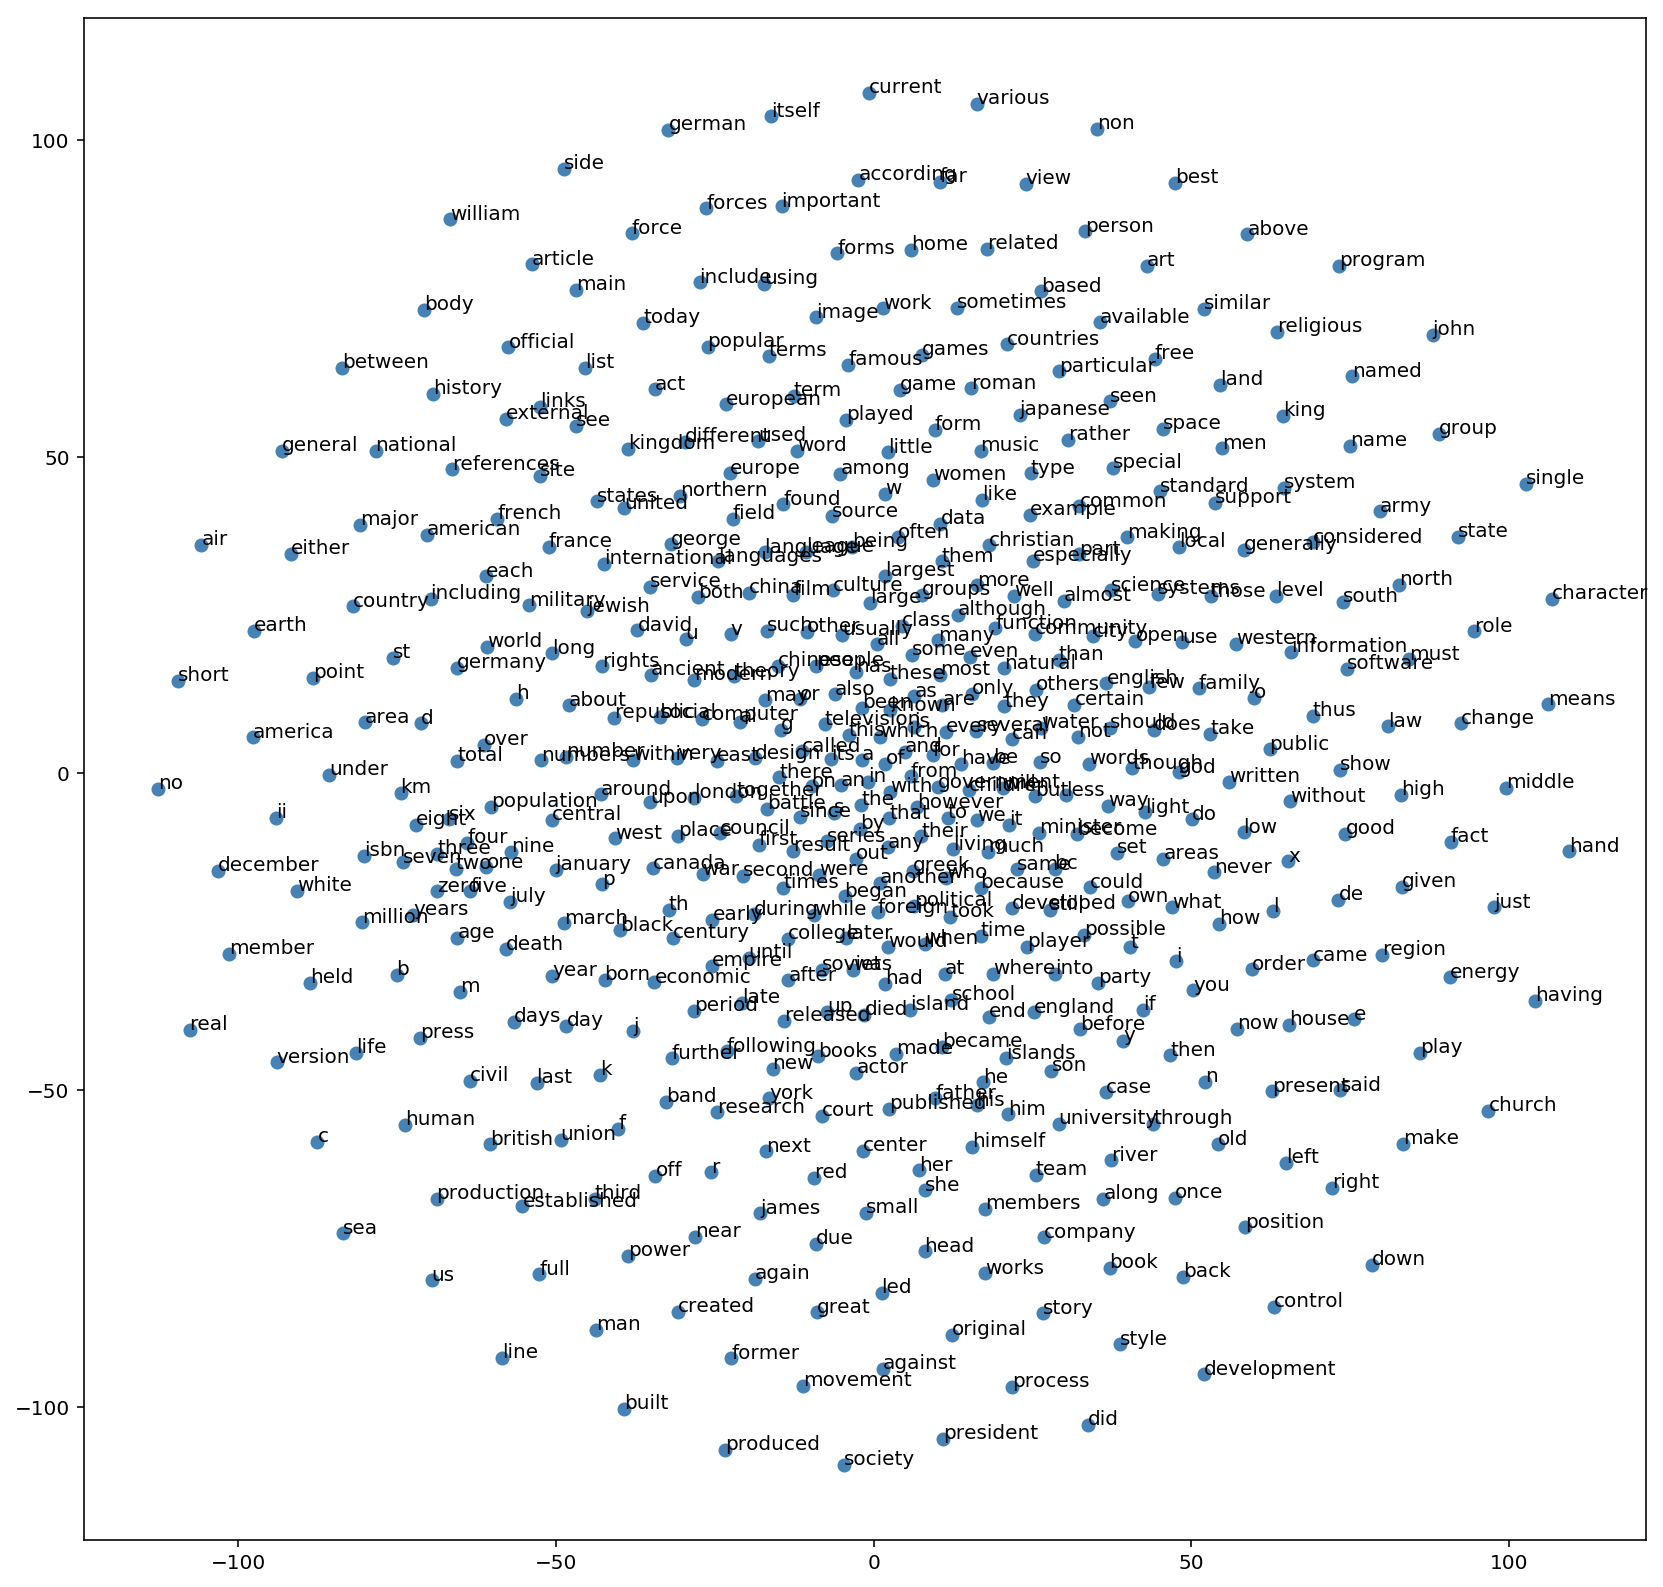

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1.0)